# Volatility Models - Project
Cojutti Francesco - Khalil Hassan - Ngoc Truong Nguyen

In [84]:
import numpy as np
import scipy.integrate as spi
import numpy.random as npr
import matplotlib.pyplot as plt
import math
import scipy.stats as stats
from scipy.stats import norm
import scipy.linalg
from random import random
import scipy.integrate as integrate
import scipy
import time
plt.style.use('seaborn')
from sklearn.linear_model import LinearRegression as lr

<ipython-input-84-58c052ff0f94>:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## Exercise 1

In [85]:
#Parameters
n=20
V0=0.05
lam=0.3
teta=0.05
nu=0.1
alpha=0.6
r=2.5

#### 1) We simulate and plot a path of the variance process $(V_{tk})_{k=0}^m$ on the interval $[0,1]$ using a uniform partition $t_0 = 0 ,... ,t_m = m∆t$ with $m = 10^5$ (and $∆t = 10^{−5}$).  For the simulation we use the method described in slide 19 of Part III of the lectures.

In [86]:
#Weights and Mean Reversions
c, x = np.linspace(1,n,n), np.linspace(1,n,n)

func_c = lambda t: (pow(r,1-alpha)-1)*pow(r,(1-alpha)*(t-1-n/2))/(math.gamma(alpha)*math.gamma(2-alpha))
c = np.array([func_c(ci) for ci in c])

func_x = lambda t: (1-alpha)*(pow(r,2-alpha)-1)/((2-alpha)*(pow(r,1-alpha)-1))*pow(r,t-1-n/2)
x = np.array([func_x(xi) for xi in x])

In [87]:
#Function to compute g0(t)
def g0(t):
  S = [c[i] * (1 / x[i] - 1 / x[i] * np.exp(-x[i] * t))  for i in range(n)]   #computing analytically the integral

  return V0+lam*teta*np.sum(S)

In [88]:
#Setting other parameters
m=pow(10,5)
deltat=1/m
t=np.linspace(0,1,m+1)

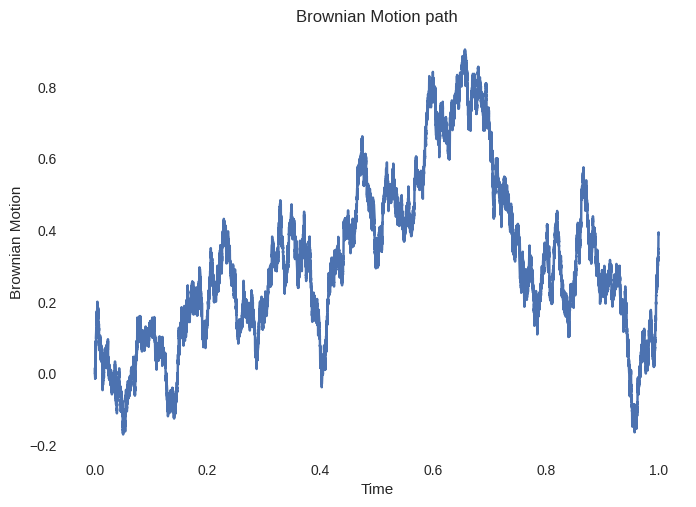

In [89]:
#Brownian Motion
dW=npr.normal(size=(m,))*np.sqrt(deltat)
W0=np.zeros(shape=(1,))
W=np.concatenate((W0,np.cumsum(dW)))
plt.plot(t,W)
plt.legend()

plt.grid(False)

plt.box(on=True)

plt.gca().set_facecolor('white')
plt.xlabel('Time')
plt.ylabel('Brownian Motion')
plt.title('Brownian Motion path')
plt.show()

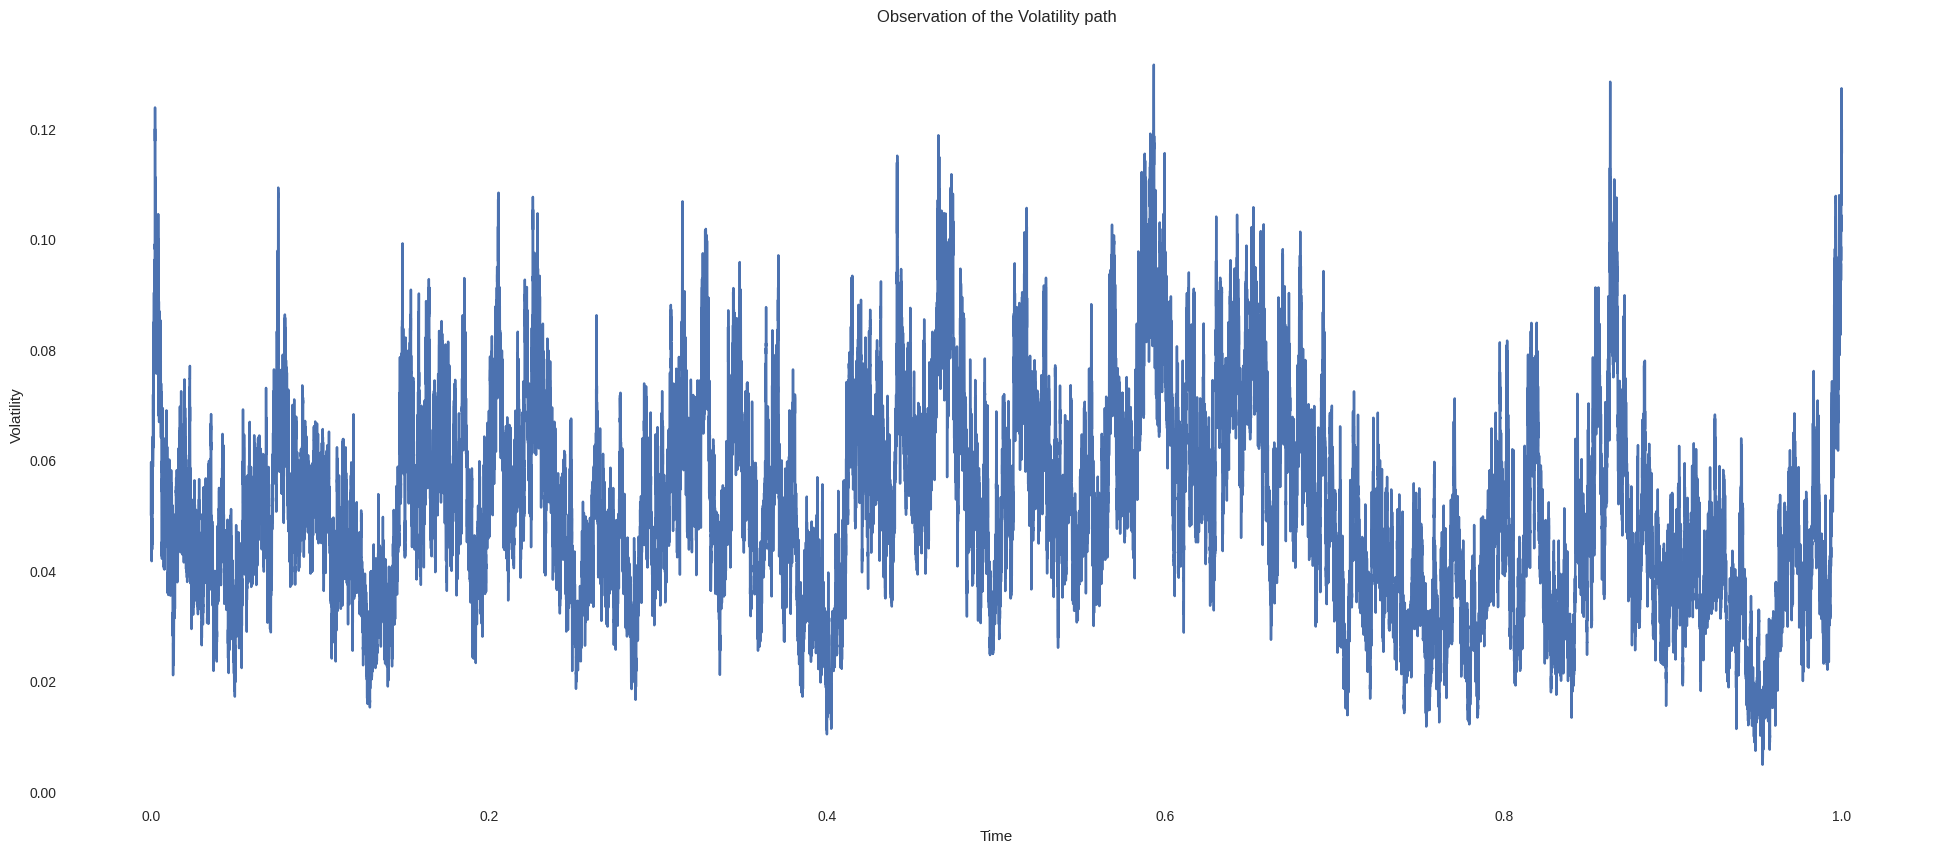

In [90]:
#Algorithm to simulate V
U = np.zeros((m + 1, n))
V = np.zeros(m + 1)
for s in range(len(t)):
  V[s] = g0(t[s]) + np.sum(c*U[s])
  for i in range(n):
    if(s!=len(t)-1):
     U[s+1][i] = 1 / (1 + x[i]*deltat) * (U[s][i] - lam * V[s] * deltat + nu * np.sqrt(max(0, V[s])) * (W[s+1]-W[s]))

plt.figure(figsize= [24,10])
plt.plot(t, V)
plt.grid(False)

plt.box(on=True)

plt.gca().set_facecolor('white')

plt.xlabel('Time')
plt.ylabel('Volatility')
plt.title('Observation of the Volatility path')

plt.show()

#### 2) Using the method described in the first lecture (slide 39 of Part I with $W^H$ replaced by $V$) we estimate the value of $H$ for the simulation in part 1 by using moments $q= 0.5,1,1.5,2$ and lags $∆ = 1,...,10$.

In [91]:
q = [0.5, 1, 1.5, 2]
delta = range(1, 10)

In [92]:
#Function to estimate H following the algorithm of Lecture 1
def estimate_H_BM(V, delta, q):

    m_q = []
    for qq in q:
        row = []
        for d in delta:
            M = len(V) - d
            S = 0
            for i in range(M):
                S += abs(V[i+d] - V[i])**qq
            row.append(S/M)
        m_q.append(row)
    coeff_1 = []
    interc_1 = []
    xx = np.linspace(0, max(np.log(delta)), 100)
    yy =[]
    for i in range(len(q)):
        # Perform the first linear regression to find the best linear fit for log(m(q; Delta)) as a
        # function of log(Delta) for all the values of q.
        reg = lr().fit(np.log(delta).reshape(-1,1), np.log(m_q[i]).reshape(-1,1))
        coeff_1.append(reg.coef_)
        interc_1.append(reg.intercept_)
        yy.append(reg.predict(xx.reshape(-1,1)))
    q = np.asarray(q)
    coeff_1 = np.asarray(coeff_1)
    # Perform the second linear regression to find the best linear fit of zeta_q as a function of q
    reg = lr().fit(q.reshape(-1,1), coeff_1.reshape(-1,1))
    H = reg.coef_[0][0]

    return H, xx, yy, m_q

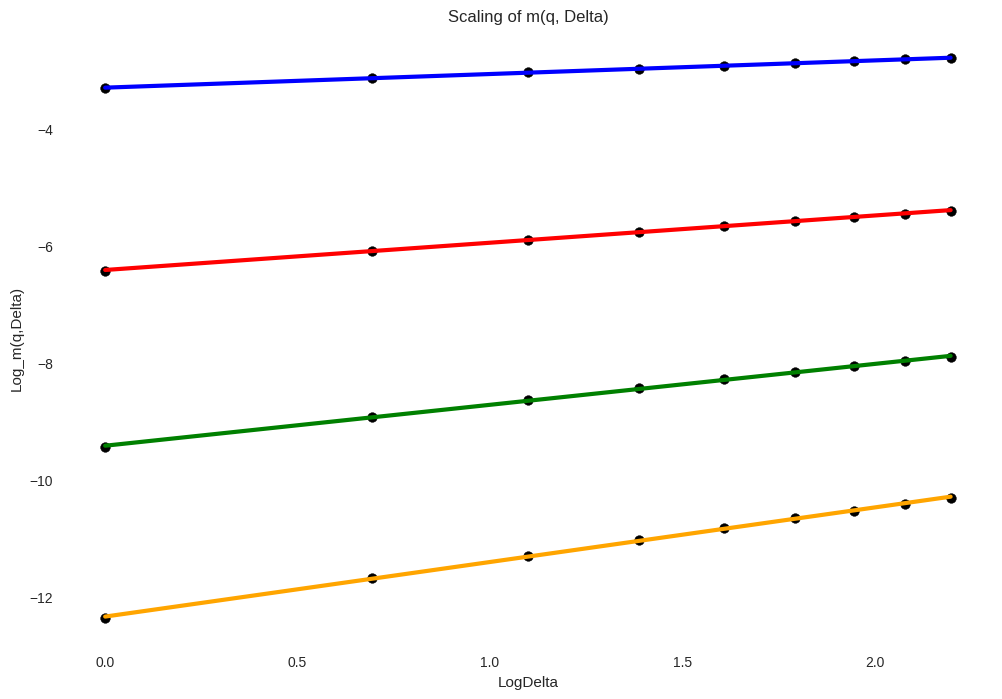

H = 0.4669347372054199


In [93]:
H, xx, yy, m_q = estimate_H_BM(V, delta, q)
colors = ['blue', 'red', 'green', 'orange', 'brown']
plt.figure(figsize=(12,8))
for i in range(len(q)):
    plt.scatter(np.log(delta).reshape(-1,1), np.log(m_q[i]).reshape(-1,1), color="black")
    plt.plot(xx, yy[i], color=colors[i], linewidth=3)
plt.xlabel("LogDelta")
plt.ylabel("Log_m(q,Delta)")
plt.title("Scaling of m(q, Delta)")
plt.grid(False)
plt.box(on=True)
plt.gca().set_facecolor('white')
plt.show()
print("H =",H)

#### 3) We repeat the estimation of $H$ from part 2 with the sampled path $V_0,V_{l∆t},V_{2l∆t},...,V_{\lfloor m/l \rfloor l∆t}$ for $l\in{1,...,10}$.  For each value of $l$ let $H(l)$ be the corresponding estimation of the parameter $H$.

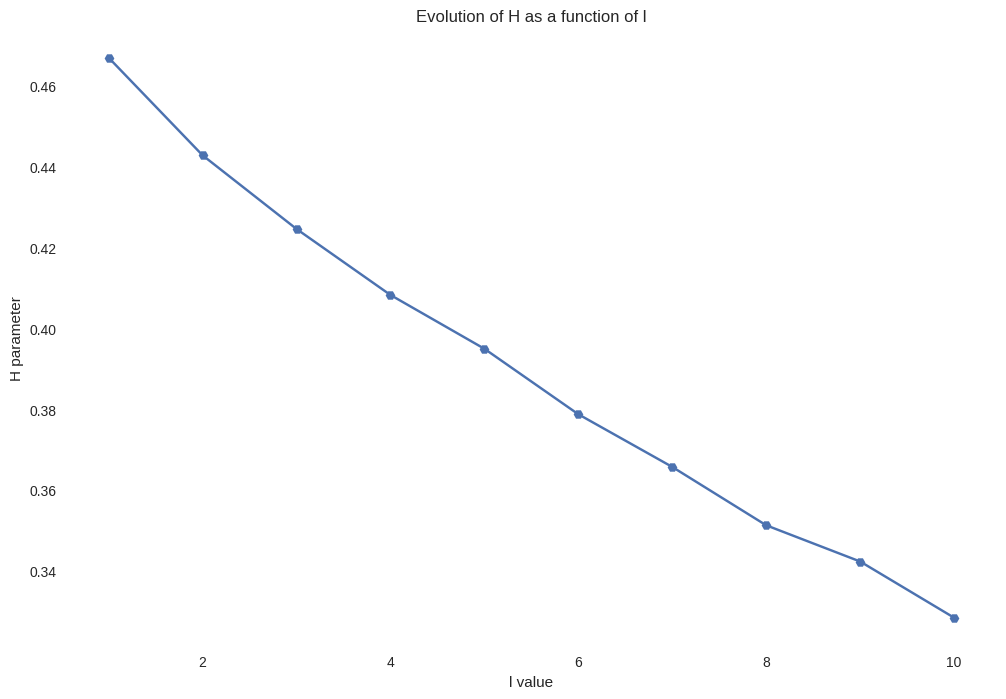

In [94]:
HH = [H]
ll = np.array([1,2,3,4,5,6,7,8,9,10])
for l in range(2, len(ll)+1):
  sample = np.linspace(0, m, int(m/l)).astype('int')
  VV = [V[i] for i in sample]
  H, _,_,_ = estimate_H_BM(VV, delta, q)
  HH.append(H)
plt.figure(figsize=(12,8))
plt.plot(ll, HH, marker='H')
plt.grid(False)
plt.box(on=True)
plt.gca().set_facecolor('white')
plt.xlabel("l value")
plt.ylabel("H parameter")
plt.title("Evolution of H as a function of l")
plt.show()

#### 4) We now repeat parts 1, 2 and 3 with $V$ replaced by a classical Brownian motion $W$


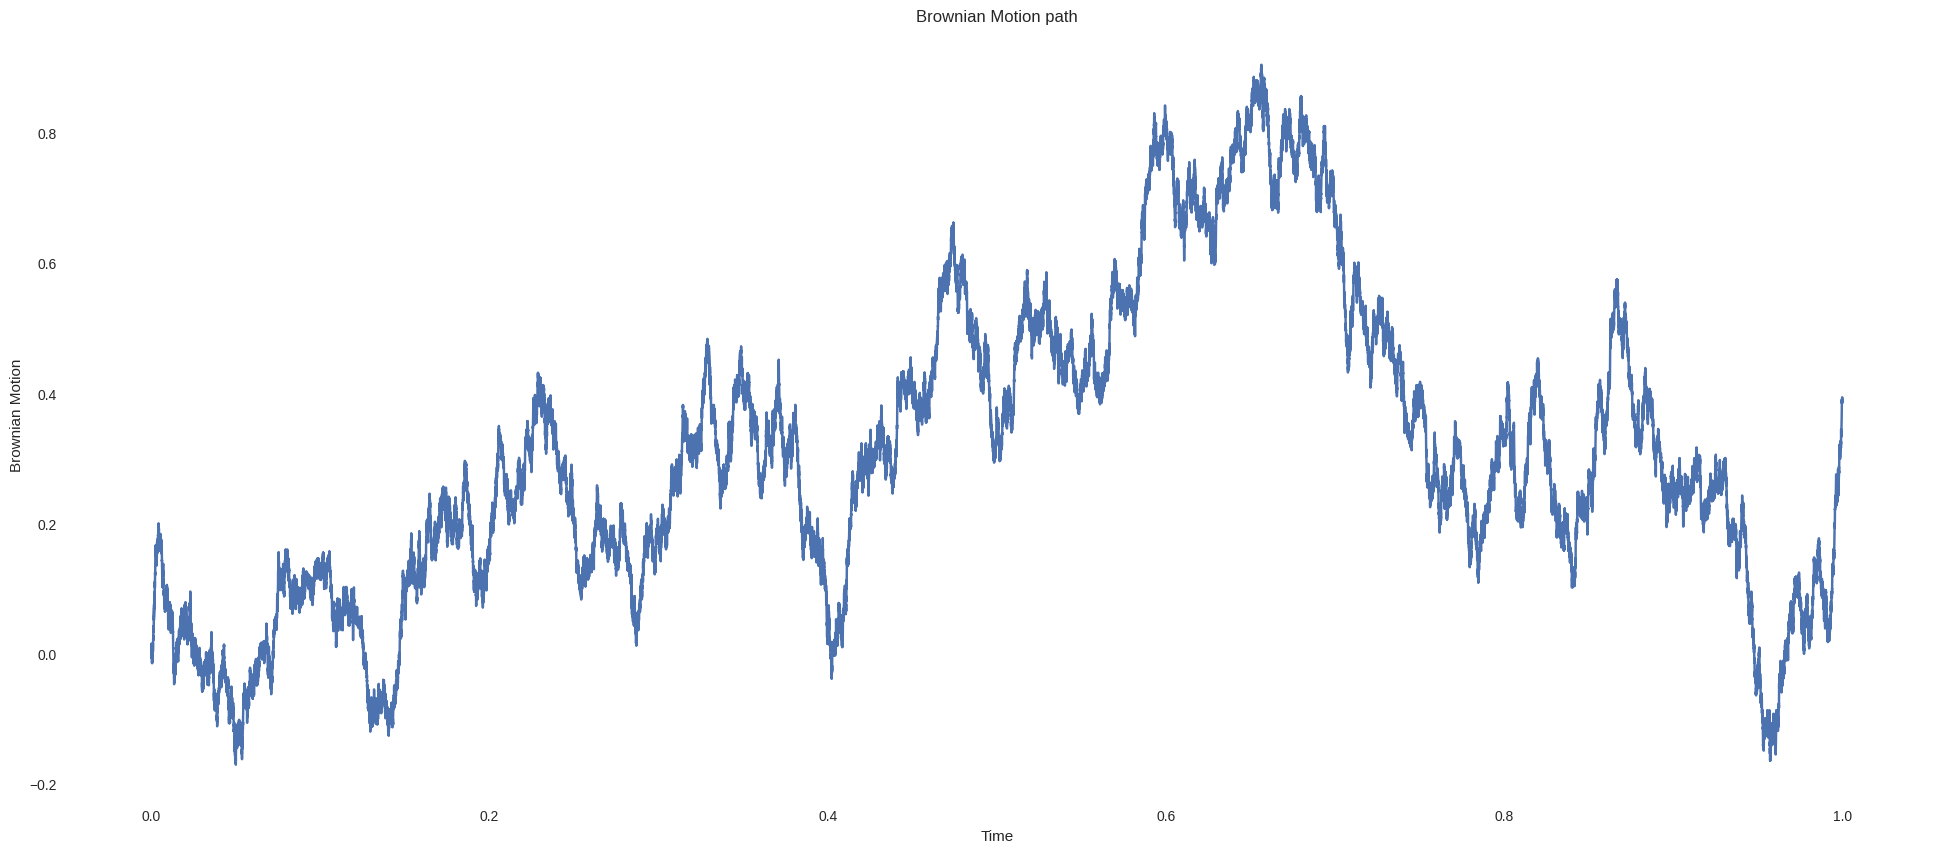

In [95]:
#Part 1
plt.figure(figsize= [24,10])
plt.plot(t,W)
plt.grid(False)
plt.box(on=True)
plt.gca().set_facecolor('white')
plt.xlabel("Time")
plt.ylabel("Brownian Motion")
plt.title('Brownian Motion path')
plt.show()

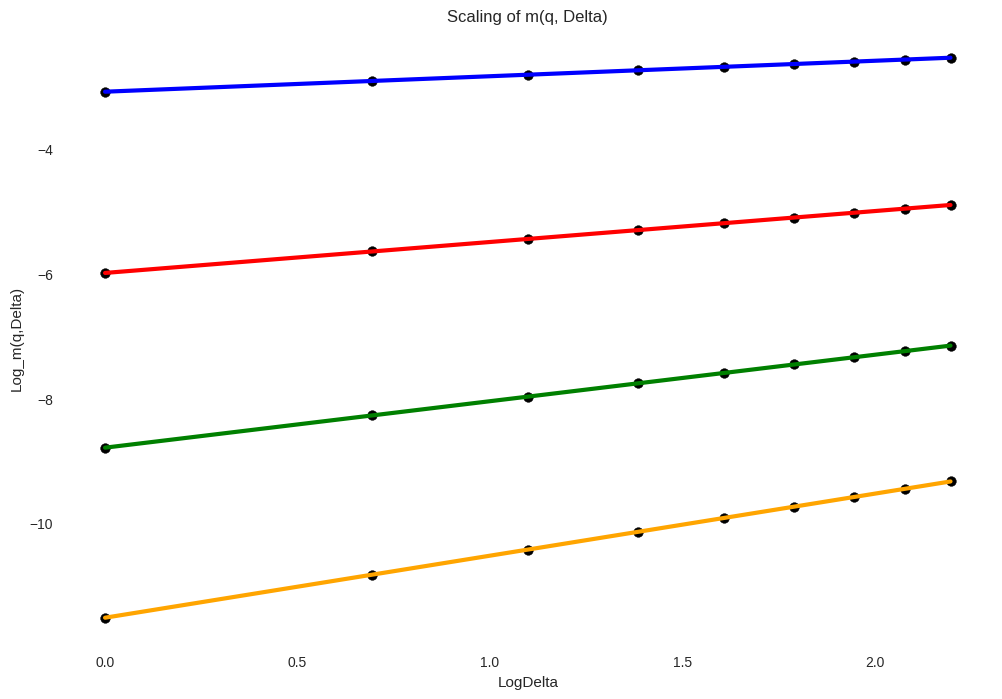

H of BM = 0.49815531297496213


In [96]:
#Part 2
H_W, xx, yy, m_q = estimate_H_BM(W, delta, q)
colors = ['blue', 'red', 'green', 'orange', 'brown']
plt.figure(figsize=(12,8))
for i in range(len(q)):
    plt.scatter(np.log(delta).reshape(-1,1), np.log(m_q[i]).reshape(-1,1), color="black")
    plt.plot(xx, yy[i], color=colors[i], linewidth=3)
plt.xlabel("LogDelta")
plt.ylabel("Log_m(q,Delta)")
plt.title("Scaling of m(q, Delta)")
plt.grid(False)
plt.box(on=True)
plt.gca().set_facecolor('white')
plt.show()
print("H of BM =",H_W)

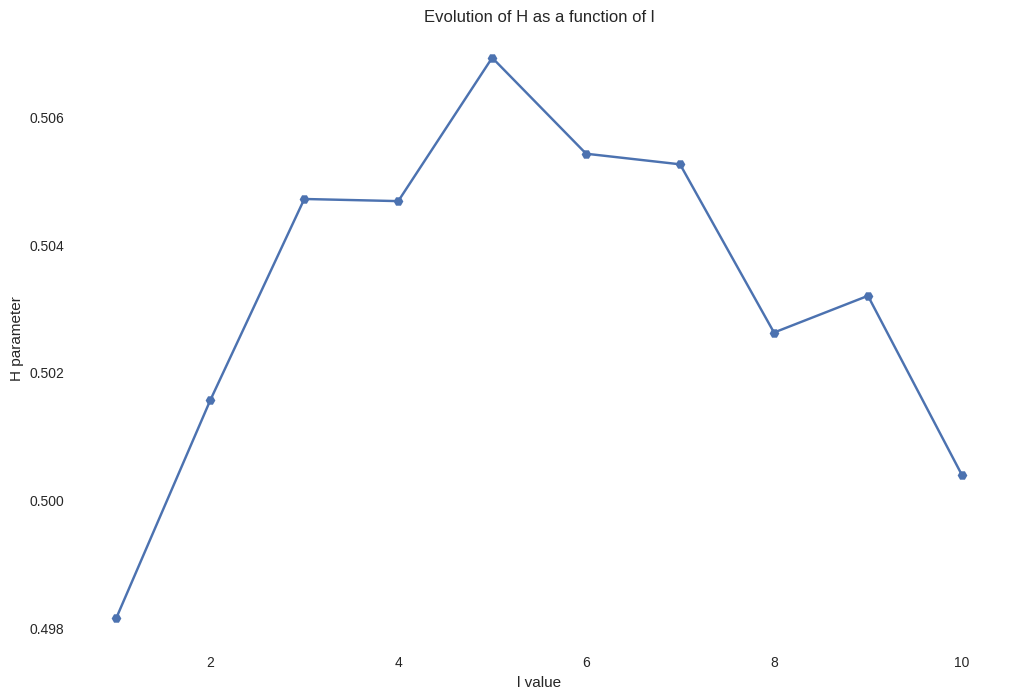

In [97]:
#Part 3
HH_W=[H_W]
ll=np.array([1,2,3,4,5,6,7,8,9,10])
for l in range(2,len(ll)+1):
  sample=np.linspace(0,m,int(m/l)).astype('int')
  WW=[W[i] for i in sample]
  H, _,_,_ = estimate_H_BM(WW, delta, q)
  HH_W.append(H)
plt.figure(figsize=(12,8))
plt.plot(ll, HH_W, marker='H')
plt.grid(False)
plt.box(on=True)
plt.gca().set_facecolor('white')
plt.xlabel("l value")
plt.ylabel("H parameter")
plt.title("Evolution of H as a function of l")
plt.show()

#### 5) Repeat parts 1, 2 and 3 with $V$ replaced by a fractional Brownian motion $W^H$ (with $H$ = 0.1). For the simulation use the Cholesky method and consider a time grid with $m = 10^3$ (and $∆t = 10^{−3}$).


In [78]:
#Covariance computation for H=0.1
def frac_cov(t, s):
    H = 0.1
    return 0.5 * (s**(2*H) + t**(2*H) - abs(t - s)**(2*H))

In [79]:
#Computation of covariance matrix
m=pow(10,3)
deltat=1/m
t=np.linspace(0,1,m+1)
Sigma = np.zeros((len(t)-1, len(t)-1))
for i in range(len(t)-1):
    for j in range(i, len(t)-1):
        Sigma[i][j] = frac_cov(t[i+1], t[j+1]) #2 min
Sigma = np.triu(Sigma, 1) + Sigma.T
print(Sigma)

[[0.25118864 0.14426999 0.13778106 ... 0.12569452 0.12569444 0.12569436]
 [0.14426999 0.28853998 0.1751324  ... 0.14447047 0.14447031 0.14447015]
 [0.13778106 0.1751324  0.31291346 ... 0.15675758 0.15675733 0.15675709]
 ...
 [0.12569452 0.14447047 0.15675758 ... 0.99959968 0.87410548 0.85552985]
 [0.12569444 0.14447031 0.15675733 ... 0.87410548 0.99979992 0.87430564]
 [0.12569436 0.14447015 0.15675709 ... 0.85552985 0.87430564 1.        ]]


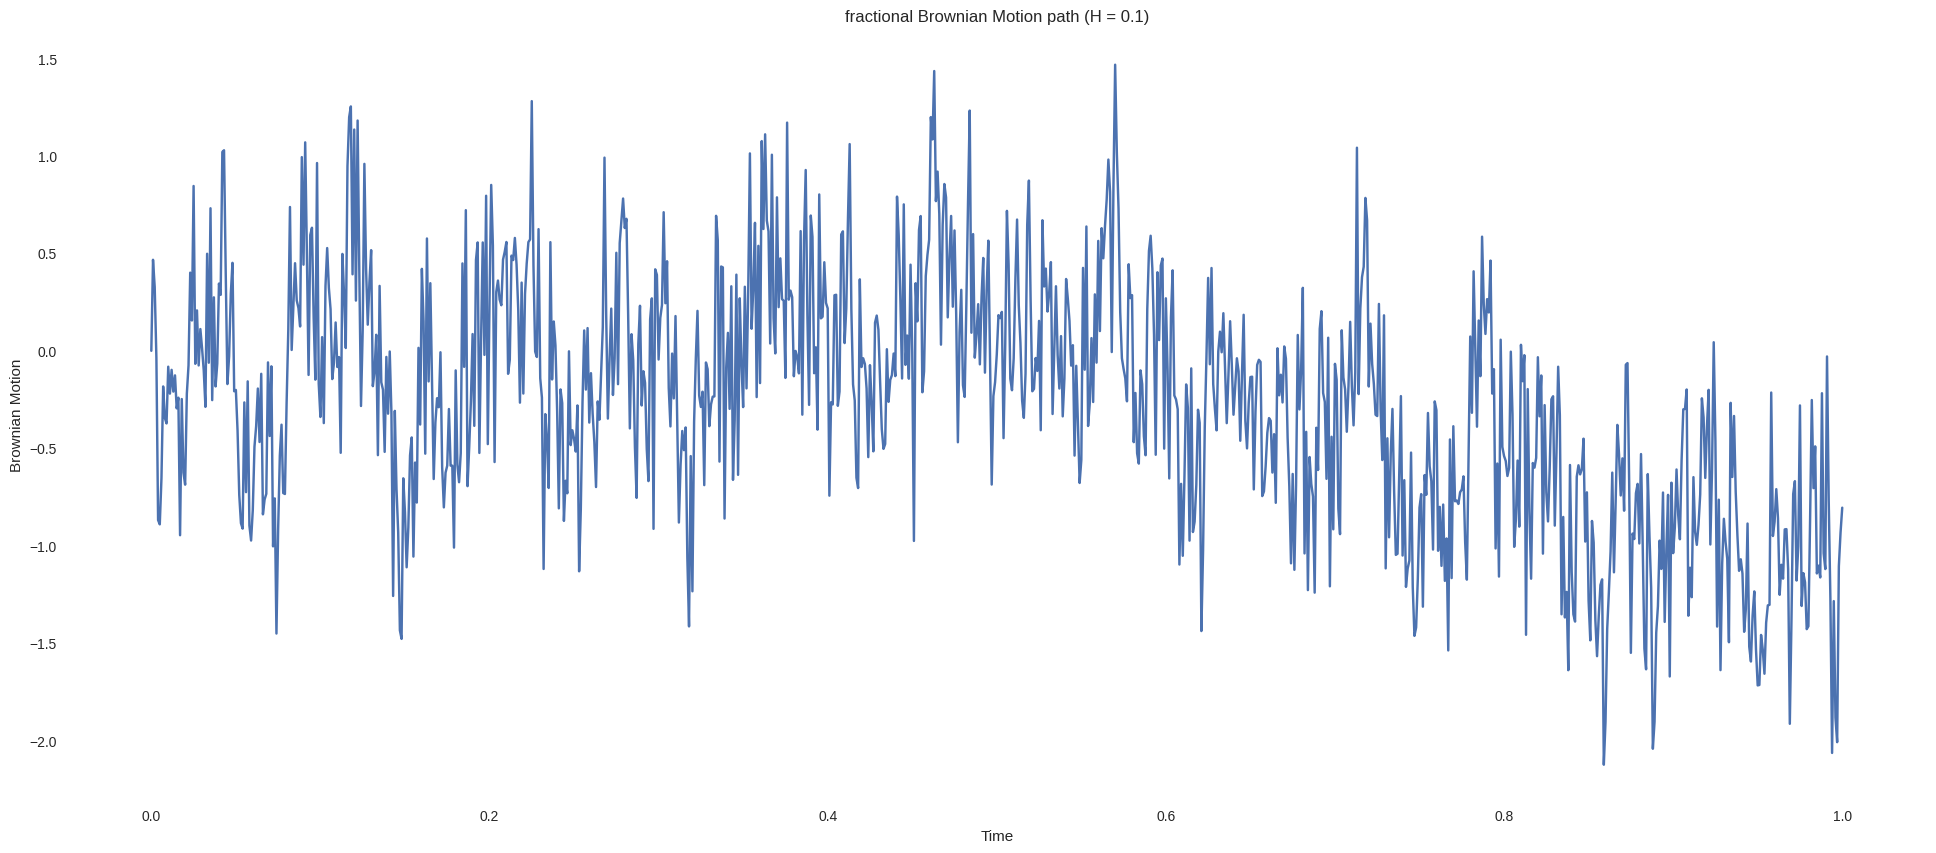

In [80]:
C = np.linalg.cholesky(Sigma) #cholesky decomposition
Z = npr.normal(size=(m,))
Y = np.matmul(C, Z)
Y = np.insert(Y, 0, 0)
plt.figure(figsize= [24,10])
plt.plot(t, Y)
plt.grid(False)
plt.box(on=True)
plt.gca().set_facecolor('white')
plt.xlabel("Time")
plt.ylabel("Brownian Motion")
plt.title('fractional Brownian Motion path (H = 0.1)')
plt.show()

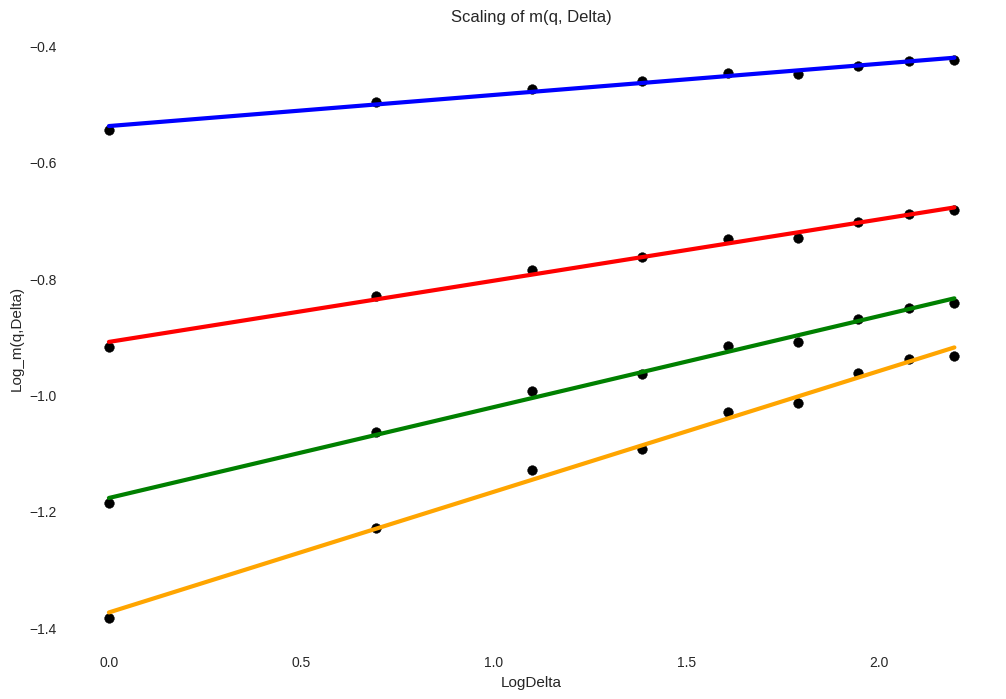

H = 0.10253282877028642


In [81]:
#part 2
H, xx, yy, m_q = estimate_H_BM(Y, delta, q)
colors = ['blue', 'red', 'green', 'orange', 'brown']
plt.figure(figsize=(12,8))
for i in range(len(q)):
    plt.scatter(np.log(delta).reshape(-1,1), np.log(m_q[i]).reshape(-1,1), color="black")
    plt.plot(xx, yy[i], color=colors[i], linewidth=3)
plt.xlabel("LogDelta")
plt.ylabel("Log_m(q,Delta)")
plt.title("Scaling of m(q, Delta)")
plt.grid(False)
plt.box(on=True)
plt.gca().set_facecolor('white')
plt.show()
print("H =",H)

We note that the estimated H is close to 0.1 (the used theoritical value used).

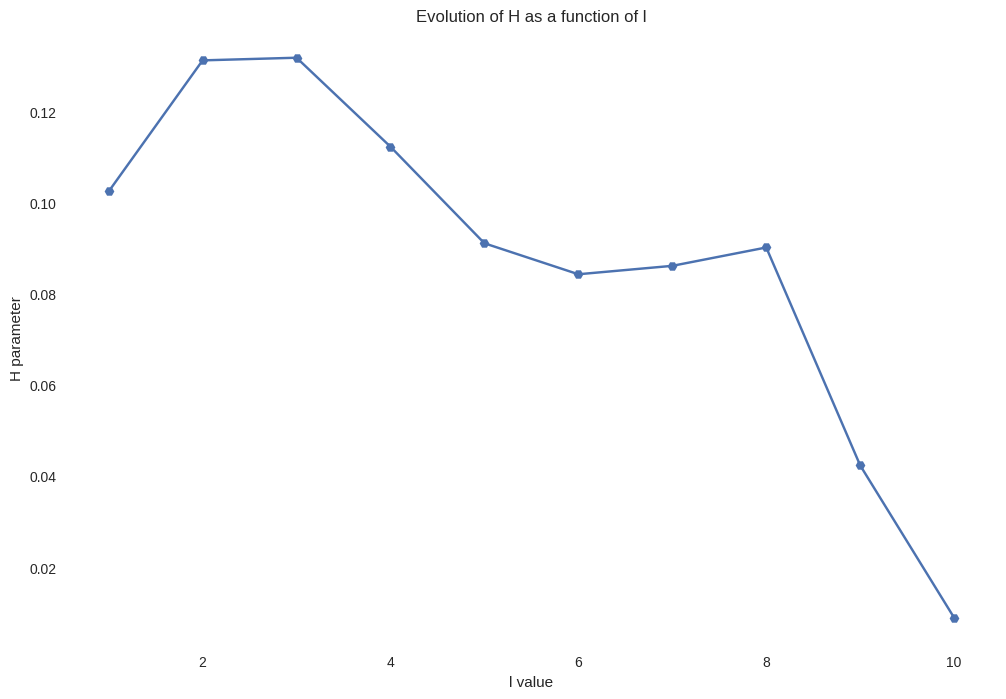

In [82]:
#Part 3
HH=[H]
ll=np.array([1,2,3,4,5,6,7,8,9,10])
for l in range(2,len(ll)+1):
  sample=np.linspace(0,m,int(m/l)).astype('int')
  YY=[Y[i] for i in sample]
  H, _,_,_ = estimate_H_BM(YY, delta, q)
  HH.append(H)
plt.figure(figsize=(12,8))
plt.plot(ll, HH, marker='H')
plt.grid(False)
plt.box(on=True)
plt.gca().set_facecolor('white')
plt.xlabel("l value")
plt.ylabel("H parameter")
plt.title("Evolution of H as a function of l")
plt.show()